In [1]:
pip install numpy matplotlib ucimlrepo scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



=== Run 1/10 ===
Convergência atingida na época 105 com melhoria média < 0.0001 por 10 épocas consecutivas.
Run 1 finalizado: Épocas = 105, Tempo = 0.17 s
Acurácia Treino: 0.7160 | Acurácia Teste: 0.7126
Train MSE: 0.19922959 | Test MSE: 0.20565202
Precisão: 0.3563, Recall: 0.5000, F1 Score: 0.4161

=== Run 2/10 ===
Convergência atingida na época 114 com melhoria média < 0.0001 por 10 épocas consecutivas.
Run 2 finalizado: Épocas = 114, Tempo = 0.18 s
Acurácia Treino: 0.7136 | Acurácia Teste: 0.7126
Train MSE: 0.21253382 | Test MSE: 0.21567396
Precisão: 0.3563, Recall: 0.5000, F1 Score: 0.4161

=== Run 3/10 ===
Convergência atingida na época 120 com melhoria média < 0.0001 por 10 épocas consecutivas.
Run 3 finalizado: Épocas = 120, Tempo = 0.18 s
Acurácia Treino: 0.7160 | Acurácia Teste: 0.7126
Train MSE: 0.20764425 | Test MSE: 0.20973565
Precisão: 0.3563, Recall: 0.5000, F1 Score: 0.4161

=== Run 4/10 ===
Convergência atingida na época 119 com melhoria média < 0.0001 por 10 épocas co

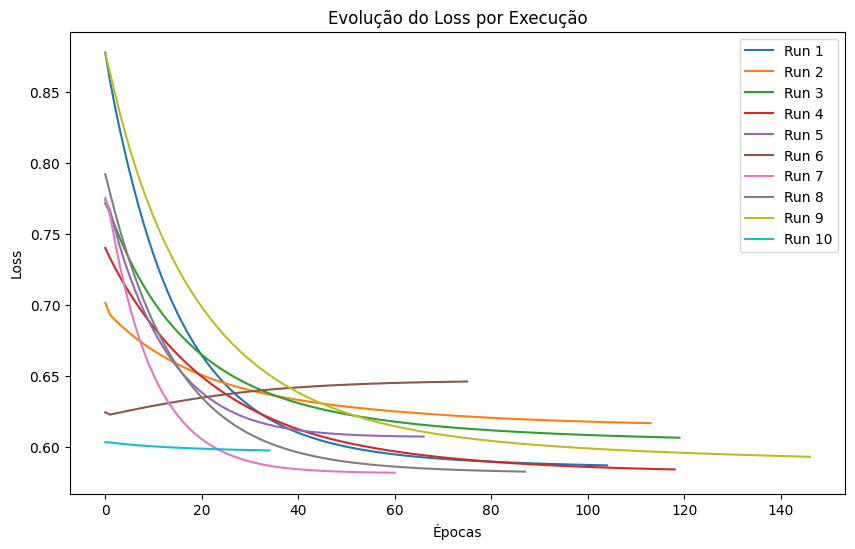

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

def one_hot_encode(y: np.ndarray, num_classes: int) -> np.ndarray:
    """Converte um vetor de rótulos em codificação one-hot."""
    return np.eye(num_classes)[y]

def load_and_preprocess_data(dataset_id: int = 225):
    """
    Carrega e pré-processa o dataset ILPD.

    - Remove linhas com valores faltantes.
    - Converte a coluna 'Gender' para numérico (caso exista).
    - Reindexa os rótulos para iniciar em 0.
    - Normaliza as features para o intervalo [0, 1].
    """
    dataset = fetch_ucirepo(id=dataset_id)

    # Cria DataFrames para features e rótulos
    features_df = dataset.data.features.copy()
    targets_df = dataset.data.targets.copy()

    # Combina features e target para remoção de linhas com valores faltantes
    data_df = features_df.copy()
    data_df['Selector'] = targets_df
    data_df.dropna(inplace=True)

    # Separa features e rótulos
    X = data_df.drop(columns=['Selector'])
    y = data_df['Selector'].values

    # Converte 'Gender' para numérico, se presente
    if 'Gender' in X.columns:
        X['Gender'] = X['Gender'].map({'Female': 0, 'Male': 1})

    # Reindexa os rótulos para começar em 0
    y = y - 1

    # Normaliza as features para o intervalo [0,1]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

def train_model(X_train: np.ndarray, y_train: np.ndarray, run: int, hidden_layers: tuple,
                activation: str, learning_rate: float, momentum: float, max_epochs: int,
                convergence_threshold: float, patience: int, num_classes: int):
    """
    Treina o MLPClassifier de forma incremental utilizando early stopping.

    Parâmetros:
    - hidden_layers: tupla com o número de neurônios para cada camada oculta.
    - activation: função de ativação a ser utilizada (ex: 'logistic', 'relu', 'tanh').

    Retorna:
    - O modelo treinado.
    - O histórico de loss.
    - O número de épocas realizadas.
    - O tempo total de treinamento.
    """
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layers,
                        activation=activation,
                        solver='sgd',
                        learning_rate_init=learning_rate,
                        momentum=momentum,
                        max_iter=1,             # 1 época por chamada
                        warm_start=True,        # permite treinamento incremental
                        shuffle=True,
                        random_state=run,
                        verbose=False)

    loss_history = []
    start_time = time.time()
    epochs_without_improvement = 0
    prev_loss = np.inf
    epoch = 0

    while epoch < max_epochs:
        if epoch == 0:
            mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))
        else:
            mlp.partial_fit(X_train, y_train)

        current_loss = mlp.loss_
        loss_history.append(current_loss)
        epoch += 1

        # Verifica melhoria do loss
        improvement = abs(prev_loss - current_loss)
        if improvement < convergence_threshold:
            epochs_without_improvement += 1
        else:
            epochs_without_improvement = 0
        prev_loss = current_loss

        # Early stopping: interrompe se não houver melhora significativa por 'patience' épocas consecutivas
        if epochs_without_improvement >= patience:
            print(f"Convergência atingida na época {epoch} com melhoria média < {convergence_threshold} por {patience} épocas consecutivas.")
            break

    training_time = time.time() - start_time
    return mlp, loss_history, epoch, training_time

def evaluate_model(model: MLPClassifier, X_train: np.ndarray, y_train: np.ndarray,
                   X_test: np.ndarray, y_test: np.ndarray, num_classes: int):
    """
    Avalia o modelo treinado utilizando diversas métricas.

    Retorna:
    - Acurácia no treino e no teste, precisão, recall, F1 score.
    - MSE no conjunto de treino e teste (calculado com one-hot encoding).
    """
    # Predições para teste e treino
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Probabilidades para cálculo do MSE
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    # Cálculo do MSE usando one-hot encoding
    y_train_one_hot = one_hot_encode(y_train, num_classes)
    y_test_one_hot = one_hot_encode(y_test, num_classes)

    train_mse = mean_squared_error(y_train_one_hot, y_train_proba)
    test_mse = mean_squared_error(y_test_one_hot, y_test_proba)

    # Cálculo das métricas
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

    return train_acc, test_acc, prec, rec, f1, train_mse, test_mse

def run_experiments(n_runs: int = 10, hidden_layers: tuple = (60,), activation: str = 'logistic',
                    max_epochs: int = 10000, learning_rate: float = 0.3, momentum: float = 0.1,
                    convergence_threshold: float = 1e-6, patience: int = 15):
    """
    Executa os experimentos, realizando n_runs com divisão estratificada dos dados.

    Parâmetros:
    - hidden_layers: tupla com o número de neurônios para cada camada oculta.
    - activation: função de ativação a ser utilizada.

    Armazena e retorna todas as métricas e históricos de treinamento.
    """
    X, y = load_and_preprocess_data()
    num_classes = len(np.unique(y))

    # Inicializa dicionário para armazenar métricas
    metrics = {
        "train_accuracy": [],
        "test_accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
        "train_mse": [],
        "test_mse": [],
        "epochs": [],
        "training_time": [],
        "loss_history": []
    }

    for run in range(n_runs):
        print(f"\n=== Run {run+1}/{n_runs} ===")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=run
        )

        model, loss_history, epochs, training_time = train_model(
            X_train, y_train, run, hidden_layers, activation, learning_rate, momentum,
            max_epochs, convergence_threshold, patience, num_classes
        )

        train_acc, test_acc, prec, rec, f1, train_mse, test_mse = evaluate_model(
            model, X_train, y_train, X_test, y_test, num_classes
        )

        # Armazena resultados da execução
        metrics["train_accuracy"].append(train_acc)
        metrics["test_accuracy"].append(test_acc)
        metrics["precision"].append(prec)
        metrics["recall"].append(rec)
        metrics["f1_score"].append(f1)
        metrics["train_mse"].append(train_mse)
        metrics["test_mse"].append(test_mse)
        metrics["epochs"].append(epochs)
        metrics["training_time"].append(training_time)
        metrics["loss_history"].append(loss_history)

        print(f"Run {run+1} finalizado: Épocas = {epochs}, Tempo = {training_time:.2f} s")
        print(f"Acurácia Treino: {train_acc:.4f} | Acurácia Teste: {test_acc:.4f}")
        print(f"Train MSE: {train_mse:.8f} | Test MSE: {test_mse:.8f}")
        print(f"Precisão: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

    return metrics

def plot_loss_history(loss_history_runs):
    """Plota a evolução do loss para cada execução."""
    plt.figure(figsize=(10, 6))
    for i, loss_history in enumerate(loss_history_runs):
        plt.plot(loss_history, label=f'Run {i+1}')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Evolução do Loss por Execução')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Parâmetros do experimento
    n_runs = 10
    hidden_layers = (20)             # Exemplo: (60, 30) duas camadas ocultas com 60 e 30 neurônios, respectivamente
    activation = 'relu'              # Pode ser 'logistic', 'relu', 'tanh', etc.
    max_epochs = 10000
    learning_rate = 0.01
    momentum = 0.1
    convergence_threshold = 1e-4
    patience = 10

    # Executa os experimentos e coleta as métricas
    metrics = run_experiments(
        n_runs=n_runs,
        hidden_layers=hidden_layers,
        activation=activation,
        max_epochs=max_epochs,
        learning_rate=learning_rate,
        momentum=momentum,
        convergence_threshold=convergence_threshold,
        patience=patience
    )

    # Exibe resultados médios
    print("\n=== Resultados Médios ===")
    print(f"Acurácia Treino Média: {np.mean(metrics['train_accuracy']):.4f}")
    print(f"Acurácia Teste Média: {np.mean(metrics['test_accuracy']):.4f}")
    print(f"Precisão Média: {np.mean(metrics['precision']):.4f}")
    print(f"Recall Médio: {np.mean(metrics['recall']):.4f}")
    print(f"F1 Score Médio: {np.mean(metrics['f1_score']):.4f}")
    print(f"Epochs Médias: {np.mean(metrics['epochs']):.2f}")
    print(f"Tempo de Treinamento Médio: {np.mean(metrics['training_time']):.2f} s")

    # Plota a evolução do loss para cada run
    plot_loss_history(metrics['loss_history'])